## MESA

Mesa is an agent-based modeling (or ABM) framework in Python. It enables users to quickly develop ABMs. It provides a variety of convenience components often used in ABMs, like different kinds of spaces within which agents can interact, sophisticaed support for controlling which agents in what order are making their moves, and basic support for dealing with the intrinsic stochastic nature of ABMs. MESA is ideally suited for learning agent-based modeling. It is less suited for developing large-scale computationally heavy ABMs because of intrinsic runtime limitations of Python. Given that MESA is a Python library, and its focus is on learning ABM, we have chosen to use MESA. The documentation of MESA can be found online: https://mesa.readthedocs.io/latest/. Besides this tutorial, we recommend you to use it when you are making your assignments for more detailed information.

Note that in this course we will be using MESA 3.0. This version of MESA is just released and comes with various backward incompatible changes. This implies that online resources might be outdated and LLM's are likely to produce eroneous code. You can check the version of MESA that you have installed via

```python
import mesa
print(mesa.__version__)
```

Any Agent Based Model is typically composed of a collection of **Agents**, which are positioned in a **Space**. The Agents interact with each other typically based on how close they are in the Space. Sometimes they also interact with the Space itself. Agent Based Models are dynamic so they show some kind of pattern over time. To create this dynamic, Agent Based Models use **ticks**. A tick is like a timestep. In each tick, all agents are given the option to act. The order in which Agents can act is very important because Agent Based Models are prone to showing path dependence. In MESA, we can explicitly control this via `model.agents`, which returns an `AgentSet` instance.

Let's build a very simple Agent Based Model, using MESA which contains these four components: Agents, Space, agent activation, and ticks. The model we will build is a simple model of an economy. It consists of a collection of agents which move around randomly in a grid like space. If, after having moved, an agent find itself in a gridcell occopied by  other agents, the agent will give one unit of wealth to a randomly selected other agent in the same grid cell. 

To implement this model, we will extend the Agent and Model class provided by MESA. As space, we will use a MultiGrid. This is a gridd (think excel-like) space where more than one agent can occupy the same cell. As scheduler, we will use the RandomActiviation. This means that at each tick, all agents in a random order get to make their move. 

So we start with importing the classes from MESA that we need.

In [1]:
from mesa import Agent, Model, DataCollector
from mesa.space import MultiGrid

Next, we can extend the MESA Model class. For this, we have to implement the `__init__` and the `step` method. The `__init__` is the initial setup of the model (tick=0). So we give our model a space (i.e., `self.grid = MultiGrid(width, height, True)`. There is no value in running a simulation model without also collecting relevant outcomes from this simulation. In Mesa, this is handled by the datacolllector.These statistitcs can be gathered at the level of the model to capture aggregate emergent behavior, but also at the agent level to gathered detailed microdata. In this particular case, we track the GINI coefficient which is a measure of wealth inequality. This is thus an aggregate metric. To calculate it, we implement the `compute_gini` function. We also want to track the agent level wealth. So, we instantiate a `DataCollector`:

```python
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
```

At every step of the model, so every tick, we gather the statistics using this datacollector.

Last, we need to populate the grid with agents. We do this by first creating an Agend and next placing it at a randomly selected grid cell (i.e., in the for loop). The step method is short. We first control the agent activation via `model.agents`. In this particular case, we first shuffle the order of agents, and next do the `step` method on each agent. For short, we can write this as `self.agents.shuffle_do(step)`. This order of activation is also known as random activation and one of the most common activation patterns in ABMs. 

In [4]:
def compute_gini(model):
    agent_wealths = model.agents.get("wealth")
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B



class MoneyModel(Model):
    """A model with some number of agents.
    
    Parameters
    n : int
        the number of agents in the space
    width : int
            the width of the space
    height : int
             the height of the space
    """
    def __init__(self, n=20, width=10, height=10, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        
        # the space within which agents move
        self.grid = MultiGrid(width, height, True)
        
        # initialize the model by creating N agents
        # positioned at a random location in the grid
        for _ in range(self.num_agents):
            agent = MoneyAgent(self)
            
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))
            
        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )
        self.datacollector.collect(self)  # collect data for t=0

    def step(self):
        self.agents.shuffle_do("step")
        self.datacollector.collect(self)


We also need to extend the Agent class that comes with MESA. In the simplest version, we would again only need to implement the `__init__` and the `step` method. However, in this case, we seperate the `step` method into 2 activities: moving to a randomly selected neighboring cell, and possible giving money. We place both activities in their own methods to clearly seperate these two actions (i.e., we add a `move` and `give_money` method to the Agent class). 

For the move method, we can use the grid of the model to get the neigboring cells, randomly pick one, and then inform the grid to move the agent to this randomly selected grid cell. Perhaps counterintuitively, the Agent does not change its own location. Instead, the grid space moves the Agent through the MESA-method move_agent.

For the `give_money` method, we ask the grid for a list of all agents occuping our current grid cell (with `get_cell_list_contents`). This method is only invoked if the agent has any wealth to give. If not, nothing happens. If there is more than one agent, we randomly select one agent to give wealth to.

Question: look carefully at the give_money method. Do you notice anything odd in how this is currently implemented?

answer: the agent randomly select from the list of agents currently occupying the cell. This list includes also itself, so the agent might give wealth to itself.

In [5]:

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, model):
        super().__init__(model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

This completes the setup of the model. We can now instantiate the model, and run it for a number of ticks

In [6]:
width = 10
height = 10
n_agents = 80
model = MoneyModel(n=n_agents, width=width, height=height)
n_ticks = 10
for _ in range(n_ticks):
    model.step()

As a last step, we can visualize the model results. For example, we can show a histogram of the distribution of wealth over the agents for the last timestep (i.e., 9) like this. Note how we use the datacollector to get the agent level statistics that we have been gathering over the run (ie.., `model.datacollector.get_agent_vars_dataframe().loc[9, "Wealth"]`]

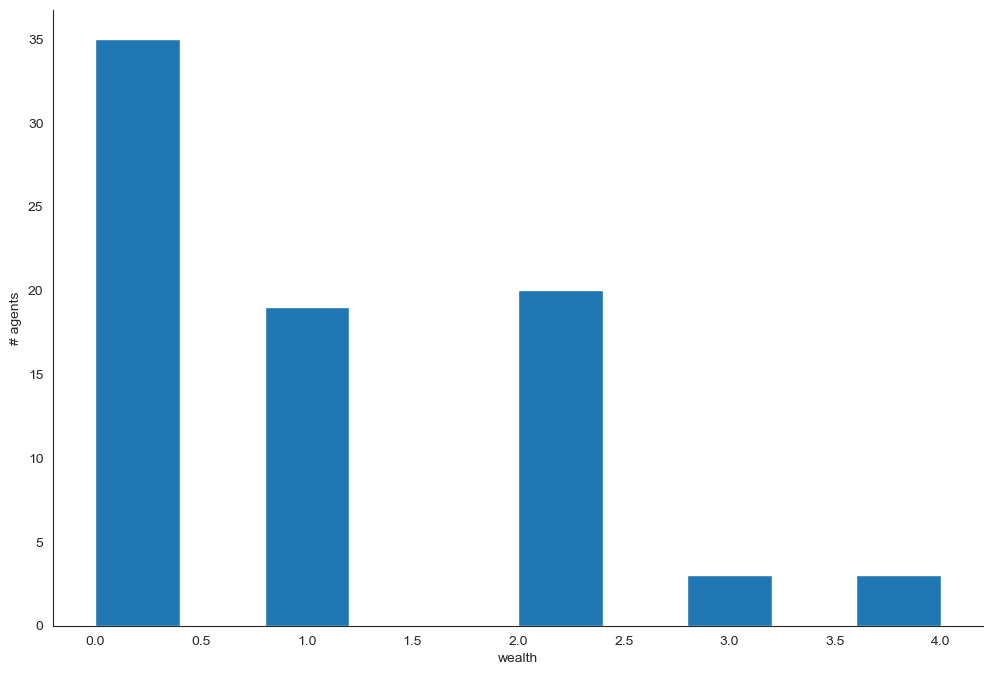

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

agent_wealth = model.datacollector.get_agent_vars_dataframe().loc[9, "Wealth"]

fig, ax = plt.subplots()

ax.hist(agent_wealth)
ax.set_ylabel('# agents')
ax.set_xlabel('wealth')

sns.despine()

plt.show()


We can also take a look at the grid itself like this:

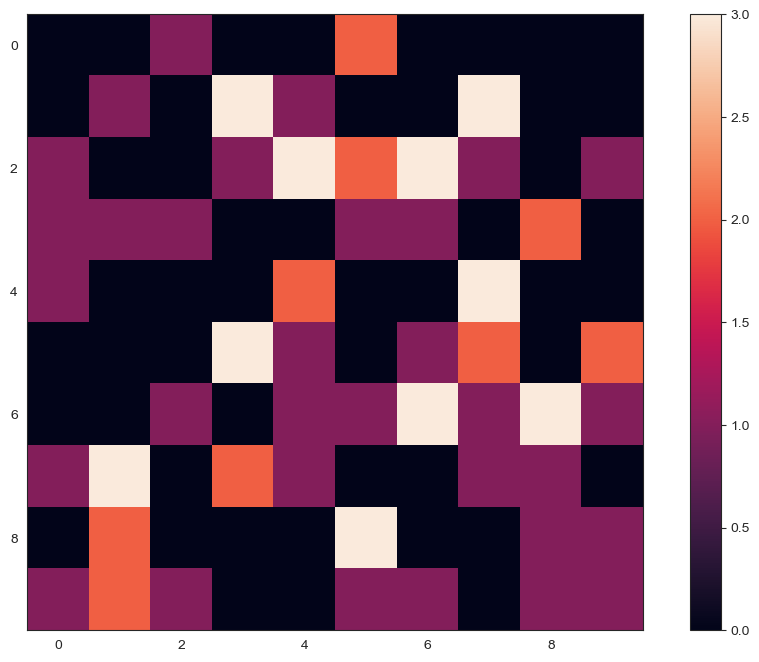

In [17]:
fig, ax = plt.subplots()

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, (x, y) = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
img = ax.imshow(agent_counts, interpolation='nearest')
fig.colorbar(img, ax=ax)
plt.show()

Assignment:

1. ABMs are stochastic models. What does this mean?
2. To create sequences of (psuedo) random numbers, computers rely on so-called random number generators. These random number generators are started from a so-called seed value and given the seed produce a sequence of random numbers. If given the same seed, the sequence of random numbers is deterministic, enabling reproducability of results. Experiment with the MoneyModel by running it 5 times for 5 different seeds. Visualize gini over time and the resulting histogram. Explain the results. 



So far, we have run the model and visualized some of the results afterwards. It is possible, however, to animate the model while it is running. The most recent version of MESA offers suport for doing this within a Jupyter notebook. Note that this is still an experimental feature which is under active development. It also makes various strong assumptions on implementation details regarding the model (i.e., the model needs to have a grid, and datacollector). 

Below we first define a function `agent_portrayal` which maps the agent and its state into a visual representation. Next, we specify the parameters in the model that we should be able to change from the interface (`model_params`). We can only control the `N` parameter. Note how this name is identical to one of the arguments that goes into the `__init__` of the model class. Width and height are fixed to 10, and again match arguments that the model needs when it is instantiated.

In [21]:
from mesa.visualization import (
    SolaraViz,
    make_plot_component,
    make_space_component,
)

In [22]:


def agent_portrayal(agent):
    size = 10
    color = "tab:red"
    if agent.wealth > 0:
        size = 50
        color = "tab:blue"
    return {"size": size, "color": color}


model_params = {
    "n": {
        "type": "SliderInt",
        "value": 50,
        "label": "Number of agents:",
        "min": 10,
        "max": 100,
        "step": 1,
    },
    "width": 10,
    "height": 10,
}

# Create initial model instance
model = MoneyModel(50, 10, 10)


SpaceGraph = make_space_component(agent_portrayal)
GiniPlot = make_plot_component("Gini")

page = SolaraViz(
    model,
    components=[SpaceGraph, GiniPlot],
    model_params=model_params,
    name="Boltzmann Wealth Model",
)
# This is required to render the visualization in the Jupyter notebook
page

Cannot show ipywidgets in text